In [3]:
# -*- coding: utf-8 -*-
"""
Titulo: Automatizacion reportes regionales (V3)
Created on Fri Dic 2 16:24:52 2023

Proceso que automatiza reportes regionales, generando un documento word por cada region a partir de template y Base de datos.

Obs: Se deben revisar los inputs antes de correr
     Refinar funciones
     Eliminar librerías sin uso

@author: diego.martinez
"""

# =============================================================================
# Extracción en python de datos de comunicado de compras a nivel regional
# =============================================================================

#Seteo de librerias

import pandas as pd
import numpy as np
import sqlalchemy as sa              #Para conexión a BD, requerido para usar pd.read_sql()
import urllib                        #Para formatear string de conexión

import docx
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import openpyxl as opxl             # OJO EN LA CASA para importar excel como dataframe

from docx import Document
from docx.shared import Inches
from docxtpl import DocxTemplate, InlineImage   #rellenar templates

import os
from pylab import savefig
import itertools

import pyodbc                               ### another engine to make DB connection and run the queries. Alternative to sqlalchemy
from itertools import repeat
import querysGR as qg

import sys
import define_funciones as dfn


In [4]:
#Transforma codigo a word
#Agregar github


#Conexion a DW

#param = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.202;UID=datawarehouse;PWD=datawarehouse;DATABASE=DM_Transaccional")#;Trusted_Connection=yes
#conn = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param)

#param = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.227;UID=eymetric;PWD=Eym3tr1c.2022;DATABASE=DM_Transaccional_2022")#;Trusted_Connection=yes
#conn = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param)

#A DCCPProcurement
#paramAQ = urllib.parse.quote_plus("DRIVER={ODBC Driver 13 for SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.145;UID=datawarehouse;PWD=datawarehouse")
#bd = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % paramAQ)
#paramAQ = urllib.parse.quote_plus("DRIVER={ODBC Driver 13 for SQL Server};SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse")
#bd = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % paramAQ)


#**** BBDD *****

# Verificar Drivers

###### DW ######


param_DW = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.202;UID=datawarehouse;PWD=datawarehouse;DATABASE=DM_Transaccional;TrustServerCertificate=yes")
conn_DW = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_DW)


##### DEV #####

param_dev = urllib.parse.quote_plus("DRIVER={/opt/microsoft/msodbcsql18/lib64/libmsodbcsql-18.2.so.2.1};SERVER=10.34.71.227;UID=eymetric;PWD=Eym3tr1c.2022;DATABASE=DM_Transaccional_2022;TrustServerCertificate=yes")
conn_dev = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_dev)

##### AQUILES #####

param_AQ = urllib.parse.quote_plus("DRIVER={SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse;DATABASE=DCCPProcurement;TrustServerCertificate=yes")
conn_AQ = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_AQ)

### connections with pyodbc ###
conn_AQ_pyodbc=pyodbc.connect('DRIVER={SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse;DATABASE=DCCPProcurement;TrustServerCertificate=yes')#;Encrypt=yes')#;TrustServerCertificate=yes')#;TrustServerCertificate=yes')
#conn_AQ_pyodbc = pyodbc.connect('DRIVER={SQL Server};SERVER=10.34.71.146;DATABASE=DCCPProcurement;UID=datawarehouse;PWD=datawarehouse')
cursor=conn_AQ_pyodbc.cursor()
#*************************

In [5]:
# =============================================================================
# Setteo Diccionarios Regionales y Nacional
# =============================================================================
                                  
# Diccionario Regional, adaptar nombres de BBDD
# Usar BBDD? Renombrar para diccionario con mas datos??
RegNomb =  {'Antofagasta':              {'nom':'Región de Antofagasta',                  'nomCt':'Antofagasta'},
            'Araucanía':                {'nom':'Región de La Araucanía',                 'nomCt':'La Araucanía'},
            'Arica y Parinacota':       {'nom':'Región de Arica y Parinacota',           'nomCt':'Arica y Parinacota'},
            'Atacama':                  {'nom':'Región de Atacama',                      'nomCt':'Atacama'},
            'Aysén':                    {'nom':'Región de Aysén',                        'nomCt':'Aysén'},
            'Bío-Bío':                  {'nom':'Región del Bío-Bío',                     'nomCt':'el Bío-Bío'},
            'Coquimbo':                 {'nom':'Región de Coquimbo',                     'nomCt':'Coquimbo'},
            "Lib. Gral. Bdo. O'Higgins":{'nom':"Región de O'Higgins",                    'nomCt':"O'Higgins"},
            'Los Lagos':                {'nom':'Región de Los Lagos',                    'nomCt':'Los Lagos'},
            'Los Ríos':                 {'nom':'Región de Los Ríos',                     'nomCt':'Los Ríos'},
            'Magallanes y Antártica':   {'nom':'Región de Magallanes y la Antártica',    'nomCt':'Magallanes'},
            'Maule':                    {'nom':'Región del Maule',                       'nomCt':'el Maule'},
            'Metropolitana':            {'nom':'Región Metropolitana',                   'nomCt':'la R. Metropolitana'},
            'Ñuble':                    {'nom':'Región del Ñuble',                       'nomCt':'el Ñuble'},
            'Tarapacá':                 {'nom':'Región de Tarapacá',                     'nomCt':'Tarapacá'},
            'Valparaíso':               {'nom':'Región de Valparaíso',                   'nomCt':'Valparaíso'}}

#nombres meses para usar con mes_i y mes_f (int)
meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 
         'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']


In [6]:
###########################################################
###    Def parámetros indicadores y ejecución querys    ###
###########################################################

#juntar parámetros al principio, querys al final. agregar condicionalidad a ejecución de querys

#Años y meses
anoReg = 2023
anoRegM = anoReg - 1
mes_i = 1
mes_f = 12


#Setea lista de regiones
listReg = pd.read_sql(con = conn_DW,  sql = qg.queryRegiones() )
listReg = list(listReg['Region'])



In [7]:

#Totales Regionales 2023 ¿y 2022?
listColTmnReg = ['Tmn']
dtoTmnReg = 'tmnReg'


#Parametros Top Modalidad de compras
listColModReg = ['Mod']
dtoModReg = 'modReg'

#Query reg pa instituciones
listColInsReg = ['Ins']
dtoInsReg = 'insReg'


#Proveedores
dtoPrvReg = 'prvReg'
listColPrvReg = ['Prv','PrvID']


#Montos Rubros Regionales
topRubReg = 5 #query de rubro requiere el top
                #como se usarán datos solo para el gráfico se decide que el  top 5 es una cantidad adecuada
listColRubReg = ['Rub', 'Rank']
dtoRubReg = 'rubReg'


#Montos OC Regionales
listColOCReg = ['OCod', 'Ins', 'Prv', 'PrvID', 'Mtv', 'OLink']
dtoOCReg = 'ocReg'


#Montos Sectores Regionales
listColSecReg = ['Sec']
dtoSecReg = 'secReg'





In [9]:

#---querys


#Setea lista de regiones
listReg = pd.read_sql(con = conn_DW,  sql = qg.queryRegiones() )
listReg = list(listReg['Region'])


#Totales Regionales 2023 ¿y 2022?
TotReg = pd.read_sql(con = conn_DW,  sql = qg.queryTotalRegion(mes_i, mes_f) )
TotRegBig = pd.read_sql(con = conn_DW,  sql = qg.theQueryReg(mes_i, mes_f) ) #Reemplazar al de arriba?? demora
# se puede optimizar el tiempo de carga eliminando los requerimientos de para OC en theQueryReg()
#           opcionalmente se puede usar queryOrdenCompraRegionTop() para consultar las OC

#Montos Rubros Regionales
RubReg = pd.read_sql(con = conn_DW,  sql = qg.queryRubroRegion(mes_i, mes_f, topRubReg) )

#Montos Compra Agils Regional 2022 y 2023
CAReg = pd.read_sql(con = conn_DW,  sql = qg.queryCompraAgilRegion(mes_i, mes_f) )


In [10]:
TotReg

,Año,Region,Monto_Bruto_USD,Monto_Bruto_CLP,CantOC
0,2023,None,1.076433e+03,9.520010e+05,2
1,2022,Antofagasta,2.662766e+08,2.305488e+11,38240
2,2023,Antofagasta,3.991264e+08,3.344528e+11,41226
3,2022,Araucanía,5.829843e+08,5.080757e+11,140040
4,2023,Araucanía,7.567326e+08,6.355952e+11,149006
5,2022,Arica y Parinacota,1.828398e+08,1.589261e+11,34162
6,2023,Arica y Parinacota,2.769234e+08,2.363961e+11,39551
7,2022,Atacama,3.047805e+08,2.646002e+11,39344
8,2023,Atacama,2.315247e+08,1.946025e+11,42180
9,2022,Aysén,1.457441e+08,1.270409e+11,41713


In [12]:
########################################
# Grafico Regional Sectores por 3 años #
########################################


listaAnos = [2023, 2022, 2021]
listSectores = pd.read_sql(con = conn_DW,  sql = qg.querySectores())
listSectores = listSectores['Sec']

#Cambiar nombre de sector Gob. Central, Universidades a modo abreviado
listSectores2 = listSectores
#listSectores
#idx_sec = np.where(listSectores2=='Gob. Central, Universidades')[0][0]
#listSectores2[idx_sec] = 'Gob. Central, Ues.'

dfSecRegAnos = []
for i in range (0, len(listaAnos)):
    dfSecRegAnos.append(pd.read_sql(con = conn_DW,  sql = qg.querySectorRegion(mes_i, mes_f, listaAnos[i])))
dfSecRegAnos = pd.concat(dfSecRegAnos)
    
#exporta datos a excel (útil para gráficos de montos de sector por región, montos de sector por región por años, montos de sector por región nacional)
dfSecRegAnos.to_excel('SectoresRegionesAños.xlsx')




In [10]:
########################## Guardar dataframes de la sesión #######################################
#se eliminan las conexiones ya que no se pueden guaradar
#del([param_DW,param_dev,conn_dev,param_AQ,conn_AQ,conn_AQ_pyodbc,cursor,conn_DW])

#import dill                            #pip install dill --user
#filename = 'Reportes2023_procesados_20240129.pkl'
#dill.dump_session(filename)

# and to load the session again:
#dill.load_session(filename)

In [ ]:
###################################################
###   Llenado diccionario/contexto y template   ###
###################################################

#Importar template
docu = DocxTemplate("docxtpl.docx")

#Settear diccionario nacional
contextoNac = {'ano' : str(anoReg),
               'anoM' : str(anoRegM),
               'mesI' : meses[mes_i - 1],   #llama nombre del mes para usar en reporte
               'mesF' : meses[mes_f - 1]}

#settear diccionario adicionales regionales
adicionalesReg = dfn.impAdicionalesReg()



#prepara dataframe para gráficos de sector por región por año (se crea y agrega en iterador de regiones)
    #y sector por región nacional (se crea y agrega antes de iterador de regiones)

#filta año actual para gráfico sector por región nacional
dfSectorReg = dfSecRegAnos.loc[dfSecRegAnos['Ano'] == 2023]

#crea  diccionario para gráfico sector por región nacional
dcSectorReg = dfn.diccionarioGraficos(dfSectorReg, listReg, 'Region', listSectores, 'Sec')

#Crea gráfico
tituloGrafSecRegNac = 'Sector por región, nivel nacional'
dfn.graficoSectoresRegion(dcSectorReg, listSectores, tituloGrafSecRegNac)

#agrega gráfico al diccionario
img = InlineImage(docu, tituloGrafSecRegNac+'.png',width=Inches(7))
contextoNac.update({'secRegNacGrf' : img})



In [ ]:
dfn.agregarTotalesRegion(TotReg, anoReg)

##############
Antofagasta
2023
##############
<class 'pandas.core.frame.DataFrame'>
Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [8342527821.50845, 37251509977.67345, 2974154128.2221966, 104248540305.00955, 105911581141.98232, 1585944270.145451, 74138512452.58794]}

Año 2022
{2023: [8342527821.50845, 37251509977.67345, 2974154128.2221966, 104248540305.00955, 105911581141.98232, 1585944270.145451, 74138512452.58794], 2022: [6695830390.874432, 34146782962.937004, 772030578.1815182, 69620515855.48555, 43677841953.279076, 147821066.79212838, 75487990883.17282]}

Año 2021
{2023: [8342527821.50845, 37251509977.67345, 2974154128.2221966, 104248540305.00955, 105911581141.98232, 1585944270.145451, 74138512452.58794], 2022: [6695830390.874432, 34146782962.937004, 772030578.1815182, 69620515855.48555, 43677841953.279076, 147821066.79212838, 75487990883.17282], 2021: [6751838025.912011, 30342330452.65567, 842468627.4549243, 56435714789.90637, 151291073709.0229, 87525348.25, 94000118701.3557]}
{'Antofagasta': {'nom': 'Región de Antofagasta', 'nomCt': 'Antof

c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [11031689400.50522, 82699171247.33125, 621855247.9186271, 233847600836.13855, 95267097373.9063, 19509438872.16329, 192618304883.62955]}

Año 2022
{2023: [11031689400.50522, 82699171247.33125, 621855247.9186271, 233847600836.13855, 95267097373.9063, 19509438872.16329, 192618304883.62955], 2022: [6607668886.120228, 71287563906.3768, 565457510.6666853, 209199691899.95743, 48956510914.6031, 11757143555.520317, 159701677020.73987]}

Año 2021
{2023: [11031689400.50522, 82699171247.33125, 621855247.9186271, 233847600836.13855, 95267097373.9063, 19509438872.16329, 192618304883.62955], 2022: [6607668886.120228, 71287563906.3768, 565457510.6666853, 209199691899.95743, 48956510914.6031, 11757143555.520317, 159701677020.73987], 2021: [5752837859.87046, 60892597505.13434, 1438038682.4908683, 177242554837.56863, 260501153708.94983, 7282456638.197374, 149862143420.9058]}
{'Antofagasta': {'nom': 'Región de Antofagasta', 'nomCt': 'Ant

c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [9282623222.989782, 48868391917.19989, 514978268.99159014, 42657669852.875534, 99236114337.5716, 2506919955.120296, 33329360402.29563]}

Año 2022
{2023: [9282623222.989782, 48868391917.19989, 514978268.99159014, 42657669852.875534, 99236114337.5716, 2506919955.120296, 33329360402.29563], 2022: [12807655854.811323, 47454038696.71849, 2785497604.2517605, 22311361639.03936, 44227058824.06992, 2137943426.3798862, 27202504469.196182]}

Año 2021
{2023: [9282623222.989782, 48868391917.19989, 514978268.99159014, 42657669852.875534, 99236114337.5716, 2506919955.120296, 33329360402.29563], 2022: [12807655854.811323, 47454038696.71849, 2785497604.2517605, 22311361639.03936, 44227058824.06992, 2137943426.3798862, 27202504469.196182], 2021: [5688510420.597271, 34877353169.50585, 1098510117.471215, 22337773795.681816, 59787958462.30633, 296140907.0493431, 29634684196.069504]}
{'Antofagasta': {'nom': 'Región de Antofagasta', 'nomCt'

c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [2151484210.961228, 34371469673.69612, 1654480589.9331827, 49349112503.903786, 22364044429.65193, 13383079047.529999, 71328875390.73538]}

Año 2022
{2023: [2151484210.961228, 34371469673.69612, 1654480589.9331827, 49349112503.903786, 22364044429.65193, 13383079047.529999, 71328875390.73538], 2022: [1077569988.8817961, 30800713196.558136, 371050225.99487305, 48002752962.71595, 134439526735.11775, 9068300940.213675, 40840241273.259705]}

Año 2021
{2023: [2151484210.961228, 34371469673.69612, 1654480589.9331827, 49349112503.903786, 22364044429.65193, 13383079047.529999, 71328875390.73538], 2022: [1077569988.8817961, 30800713196.558136, 371050225.99487305, 48002752962.71595, 134439526735.11775, 9068300940.213675, 40840241273.259705], 2021: [1038029400.1148331, 32009331903.34028, 751625228.675978, 38410601413.26959, 61410465902.24351, 8095881122.103998, 38538148592.4566]}
{'Antofagasta': {'nom': 'Región de Antofagasta', 'n

c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [5576151045.837534, 26645390943.0525, 560676517.7728698, 51106260285.70237, 70506135667.30971, 2155064202.7822123, 46639017645.22812]}

Año 2022
{2023: [5576151045.837534, 26645390943.0525, 560676517.7728698, 51106260285.70237, 70506135667.30971, 2155064202.7822123, 46639017645.22812], 2022: [5512591032.394407, 23116650406.914036, 272191652.20512974, 28741604588.211994, 28611460612.734505, 483411527.4083011, 40302989324.07375]}

Año 2021
{2023: [5576151045.837534, 26645390943.0525, 560676517.7728698, 51106260285.70237, 70506135667.30971, 2155064202.7822123, 46639017645.22812], 2022: [5512591032.394407, 23116650406.914036, 272191652.20512974, 28741604588.211994, 28611460612.734505, 483411527.4083011, 40302989324.07375], 2021: [4804486136.200483, 17380915112.232277, 237961269.86084217, 28447210728.03417, 75025223200.50116, 46056112.33, 32256987932.041946]}
{'Antofagasta': {'nom': 'Región de Antofagasta', 'nomCt': 'Antof

c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,


Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [27781710849.19712, 83109385841.63121, 1611450022.7343016, 320022913524.71747, 114612573414.11626, 3789197872.05914, 331448450041.0164]}

Año 2022
{2023: [27781710849.19712, 83109385841.63121, 1611450022.7343016, 320022913524.71747, 114612573414.11626, 3789197872.05914, 331448450041.0164], 2022: [21603350568.0835, 54177187729.37279, 1698506249.5221639, 240106118651.89804, 189355213748.07324, 2446485721.822612, 296300517864.78595]}

Año 2021
{2023: [27781710849.19712, 83109385841.63121, 1611450022.7343016, 320022913524.71747, 114612573414.11626, 3789197872.05914, 331448450041.0164], 2022: [21603350568.0835, 54177187729.37279, 1698506249.5221639, 240106118651.89804, 189355213748.07324, 2446485721.822612, 296300517864.78595], 2021: [19597731525.344475, 51852438799.18644, 2166246484.856197, 228270484494.33655, 220507339139.0642, 431216612.5868841, 266536167115.74503]}
{'Antofagasta': {'nom': 'Región de Antofagasta', 'nomC

c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [2857742760.918498, 44339315396.41198, 2538332921.817857, 128174775434.02872, 73965433401.36948, 2427744943.7785716, 110786669893.38364]}

Año 2022
{2023: [2857742760.918498, 44339315396.41198, 2538332921.817857, 128174775434.02872, 73965433401.36948, 2427744943.7785716, 110786669893.38364], 2022: [2144808620.5104728, 40223634160.30477, 1261290420.0952764, 126520396444.18413, 96858061087.29771, 953448966.0360951, 105883907369.51465]}

Año 2021
{2023: [2857742760.918498, 44339315396.41198, 2538332921.817857, 128174775434.02872, 73965433401.36948, 2427744943.7785716, 110786669893.38364], 2022: [2144808620.5104728, 40223634160.30477, 1261290420.0952764, 126520396444.18413, 96858061087.29771, 953448966.0360951, 105883907369.51465], 2021: [2294191883.230602, 41019676763.66245, 1104670727.4273853, 85134010899.65034, 20974013518.403004, 613894739.233501, 99018466270.39331]}
{'Antofagasta': {'nom': 'Región de Antofagasta', 'n

c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,


Cantidad de datos es menor a la requerida. (tmnReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,


Cantidad de datos es menor a la requerida. (modReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [2700285617.426354, 52857625872.852745, 377764774.86619693, 191392106005.1757, 27999706543.137955, 10612689457.774115, 91903937996.90239]}

Año 2022
{2023: [2700285617.426354, 52857625872.852745, 377764774.86619693, 191392106005.1757, 27999706543.137955, 10612689457.774115, 91903937996.90239], 2022: [2369451149.675848, 43645851613.84336, 1183323659.8329077, 167280145872.2254, 79273095918.98282, 9437050103.098572, 86186991436.18166]}

Año 2021
{2023: [2700285617.426354, 52857625872.852745, 377764774.86619693, 191392106005.1757, 27999706543.137955, 10612689457.774115, 91903937996.90239], 2022: [2369451149.675848, 43645851613.84336, 1183323659.8329077, 167280145872.2254, 79273095918.98282, 9437050103.098572, 86186991436.18166], 2021: [2319222006.2586584, 47586127903.171486, 868914512.181975, 130874878679.49579, 35071270219.69318, 5774790889.606386, 75454522053.52457]}
{'Antofagasta': {'nom': 'Región de Antofagasta', 'nom

c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,


Cantidad de datos es menor a la requerida. (tmnReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,


Cantidad de datos es menor a la requerida. (modReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [10132643513.651936, 40132865207.56348, 597302582.7921449, 185207822703.59482, 44403023344.634926, 12194252288.424904, 205227508300.20078]}

Año 2022
{2023: [10132643513.651936, 40132865207.56348, 597302582.7921449, 185207822703.59482, 44403023344.634926, 12194252288.424904, 205227508300.20078], 2022: [8757886672.53609, 50058963546.11116, 1736550625.9527223, 184770874925.78015, 71147308444.55939, 11926546381.863337, 140757169317.9052]}

Año 2021
{2023: [10132643513.651936, 40132865207.56348, 597302582.7921449, 185207822703.59482, 44403023344.634926, 12194252288.424904, 205227508300.20078], 2022: [8757886672.53609, 50058963546.11116, 1736550625.9527223, 184770874925.78015, 71147308444.55939, 11926546381.863337, 140757169317.9052], 2021: [8100980616.111443, 47752564341.568634, 1430280994.3562531, 150002194611.20273, 63645293295.25204, 6598818703.640122, 149397386370.9769]}
{'Antofagasta': {'nom': 'Región de Antofagasta'

c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,


Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [3548298897.719777, 21654360953.369785, 639174514.6130661, 110861239821.3628, 113000613382.68036, 1765826118.7665055, 70345088223.34885]}

Año 2022
{2023: [3548298897.719777, 21654360953.369785, 639174514.6130661, 110861239821.3628, 113000613382.68036, 1765826118.7665055, 70345088223.34885], 2022: [3165792628.3911214, 20214464775.970867, 945411188.0672123, 90102017999.62482, 91076258979.05986, 1291472493.670058, 60556775209.12074]}

Año 2021
{2023: [3548298897.719777, 21654360953.369785, 639174514.6130661, 110861239821.3628, 113000613382.68036, 1765826118.7665055, 70345088223.34885], 2022: [3165792628.3911214, 20214464775.970867, 945411188.0672123, 90102017999.62482, 91076258979.05986, 1291472493.670058, 60556775209.12074], 2021: [3064698799.6886744, 19519992093.393463, 1430296307.646686, 98986830075.8325, 135045169513.21693, 29692866.72, 54094911668.40365]}
{'Antofagasta': {'nom': 'Región de Antofagasta', 'nomCt': 'A

c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [17223376215.498333, 26378208323.764694, 733431296.1997924, 30172881866.877052, 83534092591.16885, 3677899520.238301, 66646332730.82319]}

Año 2022
{2023: [17223376215.498333, 26378208323.764694, 733431296.1997924, 30172881866.877052, 83534092591.16885, 3677899520.238301, 66646332730.82319], 2022: [16587499240.753521, 26069757199.746365, 731795121.0104462, 23503533801.559116, 52806296025.054794, 1228906715.9902284, 44363374459.78534]}

Año 2021
{2023: [17223376215.498333, 26378208323.764694, 733431296.1997924, 30172881866.877052, 83534092591.16885, 3677899520.238301, 66646332730.82319], 2022: [16587499240.753521, 26069757199.746365, 731795121.0104462, 23503533801.559116, 52806296025.054794, 1228906715.9902284, 44363374459.78534], 2021: [14992959669.041365, 23915314255.674362, 835857430.6269261, 23114390806.058083, 35015800258.64353, 40830648.08, 45143854544.89894]}
{'Antofagasta': {'nom': 'Región de Antofagasta', 'nom

c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,


Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [3375417498.50367, 75067263714.72166, 724561623.1812159, 257694945683.3278, 110324167296.36783, 6144133588.73849, 154509508391.44202]}

Año 2022
{2023: [3375417498.50367, 75067263714.72166, 724561623.1812159, 257694945683.3278, 110324167296.36783, 6144133588.73849, 154509508391.44202], 2022: [2997814209.18843, 87328522660.33958, 474279357.6837603, 194875400137.0637, 38883374460.308464, 3031936321.9265885, 128827409671.05008]}

Año 2021
{2023: [3375417498.50367, 75067263714.72166, 724561623.1812159, 257694945683.3278, 110324167296.36783, 6144133588.73849, 154509508391.44202], 2022: [2997814209.18843, 87328522660.33958, 474279357.6837603, 194875400137.0637, 38883374460.308464, 3031936321.9265885, 128827409671.05008], 2021: [2629482428.0319114, 59949832455.01585, 318411067.33198714, 168315705179.77475, 54962540708.38477, 279147799.3842318, 132938251957.14287]}
{'Antofagasta': {'nom': 'Región de Antofagasta', 'nomCt': 'An

c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,


Cantidad de datos es menor a la requerida. (tmnReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,


Cantidad de datos es menor a la requerida. (modReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [470276918066.1365, 2204670833019.5786, 67399553174.23301, 1036278073301.9298, 624817887922.3613, 83291642863.35385, 2646609310538.7983]}

Año 2022
{2023: [470276918066.1365, 2204670833019.5786, 67399553174.23301, 1036278073301.9298, 624817887922.3613, 83291642863.35385, 2646609310538.7983], 2022: [445667298413.9013, 2303039167166.204, 79025578223.36594, 719942092656.0593, 832150278824.8226, 29770381021.991684, 2862172157018.3823]}

Año 2021
{2023: [470276918066.1365, 2204670833019.5786, 67399553174.23301, 1036278073301.9298, 624817887922.3613, 83291642863.35385, 2646609310538.7983], 2022: [445667298413.9013, 2303039167166.204, 79025578223.36594, 719942092656.0593, 832150278824.8226, 29770381021.991684, 2862172157018.3823], 2021: [348513496396.0326, 1896236382698.7148, 23120890718.221176, 595297824313.8528, 672800017528.0977, 20632758085.2507, 2566172645972.3228]}
{'Antofagasta': {'nom': 'Región de Antofagasta', 'nomC

c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,


Cantidad de datos es menor a la requerida. (tmnReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,


Cantidad de datos es menor a la requerida. (modReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [1650682912.9131136, 29370619816.39115, 654877724.8780657, 126160631345.6398, 30654901662.856125, 793219161.3508713, 95296624186.58194]}

Año 2022
{2023: [1650682912.9131136, 29370619816.39115, 654877724.8780657, 126160631345.6398, 30654901662.856125, 793219161.3508713, 95296624186.58194], 2022: [1240113284.9169333, 23348402066.84448, 247137836.3102718, 94563216666.7945, 60372987164.51487, 269000033.68228036, 72599892348.12094]}

Año 2021
{2023: [1650682912.9131136, 29370619816.39115, 654877724.8780657, 126160631345.6398, 30654901662.856125, 793219161.3508713, 95296624186.58194], 2022: [1240113284.9169333, 23348402066.84448, 247137836.3102718, 94563216666.7945, 60372987164.51487, 269000033.68228036, 72599892348.12094], 2021: [1077405356.7340105, 16879847695.290518, 342574888.49998146, 84673492431.69759, 86844844337.02115, 69322205.23095852, 60095701230.06621]}
{'Antofagasta': {'nom': 'Región de Antofagasta', 'nomCt': 

c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [9884012529.358852, 44622453269.66135, 1052384411.1516783, 69607696620.88306, 20356402731.31838, 3439549726.5839734, 52495950974.54265]}

Año 2022
{2023: [9884012529.358852, 44622453269.66135, 1052384411.1516783, 69607696620.88306, 20356402731.31838, 3439549726.5839734, 52495950974.54265], 2022: [8406823242.297599, 33707013296.9043, 1523065375.0495675, 55953151744.1813, 76062434287.85788, 175884665.4466079, 59096857402.46513]}

Año 2021
{2023: [9884012529.358852, 44622453269.66135, 1052384411.1516783, 69607696620.88306, 20356402731.31838, 3439549726.5839734, 52495950974.54265], 2022: [8406823242.297599, 33707013296.9043, 1523065375.0495675, 55953151744.1813, 76062434287.85788, 175884665.4466079, 59096857402.46513], 2021: [7177852941.198748, 26000758534.26064, 1176761430.5955467, 40389115044.87485, 10612452246.164064, 10124932.951833311, 50940369268.60683]}
{'Antofagasta': {'nom': 'Región de Antofagasta', 'nomCt': 'Ant

c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,


Cantidad de datos es menor a la requerida. (tmnReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,


Cantidad de datos es menor a la requerida. (modReg)


c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\define_funciones.py:390: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
c:\o\OneDrive - DCCP\Escritorio\Proyectos\Generador de Reportes\Generador Reportes version final\Generador Reportes 3 version final\de

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [110548919108.76607, 231703774997.623, 15328262252.631514, 328369896699.68286, 104821785188.32649, 15782406295.082233, 302590339667.3187]}

Año 2022
{2023: [110548919108.76607, 231703774997.623, 15328262252.631514, 328369896699.68286, 104821785188.32649, 15782406295.082233, 302590339667.3187], 2022: [101640185951.51173, 278830515046.7395, 16575225972.82106, 228143926293.6317, 132147010110.60008, 10071357683.111866, 248664704181.18683]}

Año 2021
{2023: [110548919108.76607, 231703774997.623, 15328262252.631514, 328369896699.68286, 104821785188.32649, 15782406295.082233, 302590339667.3187], 2022: [101640185951.51173, 278830515046.7395, 16575225972.82106, 228143926293.6317, 132147010110.60008, 10071357683.111866, 248664704181.18683], 2021: [91947377840.75708, 111590838772.87466, 10304040265.193079, 194365552628.32422, 81293377012.57785, 4224983160.213883, 215636898751.9493]}
{'Antofagasta': {'nom': 'Región de Antofagasta

<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

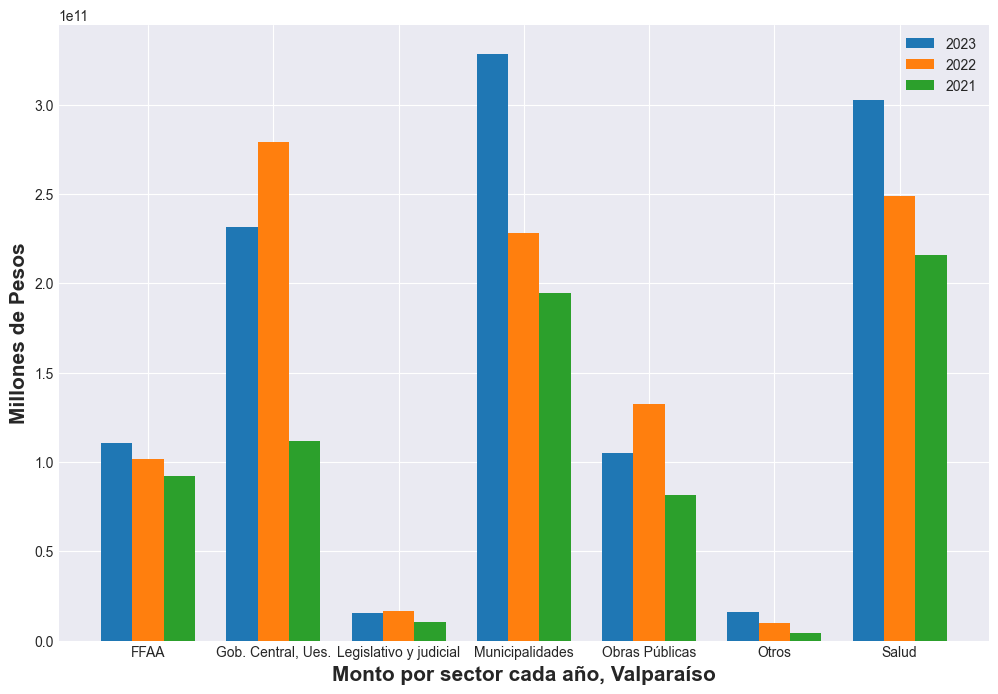

In [18]:

#diccionario que almacena los diccionarios de cada región para luego exportar una planilla con todos los datos
dicGlob = {}

anoReg = 2023
anoRegM = anoReg - 1

#Iterador de regiones/documentos
for r in listReg:
  
   print('##############')
   print(r)
   print(anoReg)
   print('##############')

   contexto = dfn.setContextoReg(r, RegNomb)

   rTotReg = TotReg.loc[TotReg['Region'] == r]
   print(type(rTotReg))

   contexto.update(dfn.agregarTotalesRegion(rTotReg, anoReg))
   

   

    #tmn Reg
   rTmnReg = dfn.extraerDataframe (TotRegBig, r, listColTmnReg)
   rTmnReg = dfn.fmtoDataframe(rTmnReg, listColTmnReg)
   contexto.update(dfn.dataframeDiciconario(rTmnReg, dtoTmnReg))

    #modalidad de compra
   rModReg = dfn.extraerDataframe (TotRegBig, r, listColModReg)
   rModReg = dfn.fmtoDataframe(rModReg, listColModReg)    
   contexto.update(dfn.dataframeDiciconario(rModReg, dtoModReg))

    
    # proveedores a los que se le compra por región
   rPrvReg = dfn.extraerDataframe (TotRegBig, r, listColPrvReg)
   rPrvReg = dfn.fmtoDataframe(rPrvReg, listColPrvReg) 
   contexto.update(dfn.dataframeDiciconario(rPrvReg, dtoPrvReg))

    # top Instituciones reg
   rInsReg = dfn.extraerDataframe (TotRegBig, r, listColInsReg)
   rInsReg = dfn.fmtoDataframe(rInsReg, listColInsReg)    
   contexto.update(dfn.dataframeDiciconario(rInsReg, dtoInsReg))

    #top rubro por region (usa dataframe personalizado)
    
   RubReg.to_excel('rubroRegion.xlsx')
   rRubReg = dfn.extraerDataframe(RubReg, r, listColRubReg)
   rRubReg = dfn.fmtoDataframe(rRubReg, listColRubReg)
    
   ttlGrafRub = 'Rubros más transados, '+ RegNomb[r]['nomCt']+' (Millones de Pesos)'
   dfn.grafBarras((np.array(rRubReg['CLP'])/1000000), rRubReg[''], ttlGrafRub)
   img = InlineImage(docu, ttlGrafRub+'.png',width=Inches(7))
   contexto.update({'rubRegGrf' : img})

    #no lo pide ahora comunicaciones
    #contexto.update(dataframeDiciconario(rRubReg, dtoRubReg, topRubReg))
    
   rOCReg = dfn.extraerDataframe(TotRegBig, r, listColOCReg)
   rOCReg = dfn.fmtoDataframe(rOCReg, listColOCReg)
   contexto.update(dfn.dataframeDiciconario(rOCReg, dtoOCReg))

   rSecReg = dfn.extraerDataframe(TotRegBig, r, listColSecReg)
   rSecReg = dfn.fmtoDataframe(rSecReg, listColSecReg)
   contexto.update(dfn.dataframeDiciconario(rSecReg, dtoSecReg))

   ttlGrafSec = 'Porcentaje participación por Sector, '+ RegNomb[r]['nomCt']
   dfn.grafTorta(rSecReg['CLP'], rSecReg[''], ttlGrafSec)
   img = InlineImage(docu, ttlGrafSec+'.png',width=Inches(7))
   contexto.update({'secRegGrf' : img})

   dfSectorAno = dfSecRegAnos.loc[dfSecRegAnos['Region'] == r]
   dcSectorAno = dfn.diccionarioGraficos(dfSectorAno, listaAnos, 'Ano', listSectores, 'Sec')
   tituloGrafBarra3 = 'Monto por sector cada año, '+ RegNomb[r]['nomCt']
   dfn.grafBarrasTriple(dcSectorAno, listaAnos, listSectores, tituloGrafBarra3)
   img = InlineImage(docu, tituloGrafBarra3+'.png',width=Inches(7))
   contexto.update({'secRegAnoGrf' : img})

   rCAReg = CAReg.loc[CAReg['Region'] == r]
   contexto.update(dfn.agregarCARegion(rCAReg))

   contexto.update(adicionalesReg[r])

   contexto.update(contextoNac)
    
    
   #print(contexto)
   dicGlob.update({r: contexto})
   print(dicGlob)
   docu.render(contexto)
    #os.remove(titGrafSecReg +'.png')    #según cantidad de gráficos se podría iterar
    
   nomDocu = contexto['ano'] + ' cifras regionales ' + contexto['nomCt'] + ' ' + contexto['mesI'] + '-' + contexto['mesF']
   docu.save('reportes/'+nomDocu+'.docx')

In [12]:
#######################################################
# Exporta planilla con todos los contextos regionales #
#######################################################

dfGlob = pd.DataFrame(dicGlob)
dfGlob.to_excel('dfGlob.xlsx')

In [13]:
#############################
# Borar gráficos de carptea #
#############################


os.remove('Sector por región, nivel nacional'+'.png')
for r in listReg:
    
    os.remove('Monto por sector cada año, '+ RegNomb[r]['nomCt']+'.png')
    os.remove('Rubros más transados, '+ RegNomb[r]['nomCt']+' (Millones de Pesos)' +'.png')   
    os.remove('Porcentaje participación por Sector, '+ RegNomb[r]['nomCt'] +'.png')   